This code is mostly from Andrew Johnston, shared across our organization's slack.

In [1]:
import folium.plugins
import requests
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:
data_local: bool = True

# Get the data

The hard part is getting the data. Lots of nuance that was figured out by Andrew Johnston. Uses CMR directly.

In [3]:
def get_cmr_products(max_requests=None):
    session = requests.Session()
    cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
    search_params = {
        'provider': 'ASF',
        'collection_concept_id': 'C1595422627-ASF',
        'page_size': 2000,
    }
    headers = {}
    products = []
    
    k = 0
    while (max_requests is None) or (k < max_requests):
        response = session.get(cmr_url, params=search_params, headers=headers)
        response.raise_for_status()

        products.extend(response.json()['feed']['entry'])

        if 'CMR-Search-After' not in response.headers:
            break
        headers = {'CMR-Search-After': response.headers['CMR-Search-After']}
        k+= 1
    return products


def format_points(point_string):
    converted_to_float = [float(x) for x in point_string.split(' ')]
    points = [list(t) for t in zip(converted_to_float[1::2], converted_to_float[::2])]
    return points

def format_points_data(point_string_data):
    return format_points(point_string_data[0][0])

For exploration, fix `max_requests`.

In [4]:
%%time

if not data_local:
    sample_data = get_cmr_products(max_requests=None)
else:
    sample_data = get_cmr_products(max_requests=1)
sample_data[0]

CPU times: user 34.2 ms, sys: 11.6 ms, total: 45.8 ms
Wall time: 1.33 s


{'producer_granule_id': 'S1-GUNW-A-R-145-tops-20141015_20141003-150859-00041E_00036N-PP-5791-v2_0_5',
 'time_start': '2014-10-15T15:08:46.000Z',
 'updated': '2022-05-24T20:34:25.000Z',
 'orbit_calculated_spatial_domains': [{'orbit_number': '2842'},
  {'orbit_number': '2667'}],
 'dataset_id': 'Sentinel-1 Interferograms (BETA)',
 'data_center': 'ASF',
 'title': 'S1-GUNW-A-R-145-tops-20141015_20141003-150859-00041E_00036N-PP-5791-v2_0_5',
 'coordinate_system': 'GEODETIC',
 'day_night_flag': 'UNSPECIFIED',
 'time_end': '2014-10-15T15:09:13.000Z',
 'id': 'G2277465554-ASF',
 'original_format': 'ECHO10',
 'granule_size': '51.83100509643555',
 'browse_flag': True,
 'polygons': [['38.224056 43.542309 37.826775 40.687195 36.1908701 41.0840184 36.5896111 43.8755338 38.224056 43.542309']],
 'collection_concept_id': 'C1595422627-ASF',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
   'hreflang': 'en-US',
   'href': 'https://grfn.asf.alaska.edu/door/down

In [5]:
format_points_data(sample_data[0]['polygons'])

[[43.542309, 38.224056],
 [40.687195, 37.826775],
 [41.0840184, 36.1908701],
 [43.8755338, 36.5896111],
 [43.542309, 38.224056]]

In [6]:
df = pd.DataFrame(sample_data)
df.head()

,producer_granule_id,time_start,updated,orbit_calculated_spatial_domains,dataset_id,data_center,title,coordinate_system,day_night_flag,time_end,id,original_format,granule_size,browse_flag,polygons,collection_concept_id,online_access_flag,links
0,S1-GUNW-A-R-145-tops-20141015_20141003-150859-...,2014-10-15T15:08:46.000Z,2022-05-24T20:34:25.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150859-...,GEODETIC,UNSPECIFIED,2014-10-15T15:09:13.000Z,G2277465554-ASF,ECHO10,51.83100509643555,True,[[38.224056 43.542309 37.826775 40.687195 36.1...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
1,S1-GUNW-A-R-145-tops-20141015_20141003-150924-...,2014-10-15T15:09:10.000Z,2022-05-25T04:11:22.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150924-...,GEODETIC,UNSPECIFIED,2014-10-15T15:09:38.000Z,G2277656788-ASF,ECHO10,54.54032230377197,True,[[37.6865215 40.7403887 38.082489 43.582111 39...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
2,S1-GUNW-A-R-145-tops-20141015_20141003-150948-...,2014-10-15T15:09:35.000Z,2022-05-19T03:18:39.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150948-...,GEODETIC,UNSPECIFIED,2014-10-15T15:10:02.000Z,G2274335778-ASF,ECHO10,54.2159538269043,True,[[41.2121631 42.9404936 40.819267 39.968952 39...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
3,S1-GUNW-A-R-160-tops-20141016_20141004-154951-...,2014-10-16T15:49:38.000Z,2022-05-24T19:02:29.000Z,"[{'orbit_number': '2857'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-160-tops-20141016_20141004-154951-...,GEODETIC,UNSPECIFIED,2014-10-16T15:50:05.000Z,G2277430014-ASF,ECHO10,51.110328674316406,True,[[35.2057205 31.0157291 35.607937 33.786678 37...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
4,S1-GUNW-A-R-160-tops-20141016_20141004-155016-...,2014-10-16T15:50:03.000Z,2022-05-25T04:21:49.000Z,"[{'orbit_number': '2857'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-160-tops-20141016_20141004-155016-...,GEODETIC,UNSPECIFIED,2014-10-16T15:50:30.000Z,G2277666101-ASF,ECHO10,50.747111320495605,True,[[36.7032925 30.6844948 37.101833 33.49894 38....,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...


<AxesSubplot:>

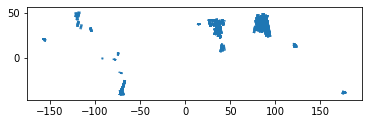

In [7]:
geometry = df.polygons.apply(format_points_data).apply(Polygon)
df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))
df.plot()

In [8]:
df.head()

,producer_granule_id,time_start,updated,orbit_calculated_spatial_domains,dataset_id,data_center,title,coordinate_system,day_night_flag,time_end,id,original_format,granule_size,browse_flag,polygons,collection_concept_id,online_access_flag,links,geometry
0,S1-GUNW-A-R-145-tops-20141015_20141003-150859-...,2014-10-15T15:08:46.000Z,2022-05-24T20:34:25.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150859-...,GEODETIC,UNSPECIFIED,2014-10-15T15:09:13.000Z,G2277465554-ASF,ECHO10,51.83100509643555,True,[[38.224056 43.542309 37.826775 40.687195 36.1...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,"POLYGON ((43.54231 38.22406, 40.68720 37.82677..."
1,S1-GUNW-A-R-145-tops-20141015_20141003-150924-...,2014-10-15T15:09:10.000Z,2022-05-25T04:11:22.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150924-...,GEODETIC,UNSPECIFIED,2014-10-15T15:09:38.000Z,G2277656788-ASF,ECHO10,54.54032230377197,True,[[37.6865215 40.7403887 38.082489 43.582111 39...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,"POLYGON ((40.74039 37.68652, 43.58211 38.08249..."
2,S1-GUNW-A-R-145-tops-20141015_20141003-150948-...,2014-10-15T15:09:35.000Z,2022-05-19T03:18:39.000Z,"[{'orbit_number': '2842'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-145-tops-20141015_20141003-150948-...,GEODETIC,UNSPECIFIED,2014-10-15T15:10:02.000Z,G2274335778-ASF,ECHO10,54.2159538269043,True,[[41.2121631 42.9404936 40.819267 39.968952 39...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,"POLYGON ((42.94049 41.21216, 39.96895 40.81927..."
3,S1-GUNW-A-R-160-tops-20141016_20141004-154951-...,2014-10-16T15:49:38.000Z,2022-05-24T19:02:29.000Z,"[{'orbit_number': '2857'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-160-tops-20141016_20141004-154951-...,GEODETIC,UNSPECIFIED,2014-10-16T15:50:05.000Z,G2277430014-ASF,ECHO10,51.110328674316406,True,[[35.2057205 31.0157291 35.607937 33.786678 37...,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,"POLYGON ((31.01573 35.20572, 33.78668 35.60794..."
4,S1-GUNW-A-R-160-tops-20141016_20141004-155016-...,2014-10-16T15:50:03.000Z,2022-05-25T04:21:49.000Z,"[{'orbit_number': '2857'}, {'orbit_number': '2...",Sentinel-1 Interferograms (BETA),ASF,S1-GUNW-A-R-160-tops-20141016_20141004-155016-...,GEODETIC,UNSPECIFIED,2014-10-16T15:50:30.000Z,G2277666101-ASF,ECHO10,50.747111320495605,True,[[36.7032925 30.6844948 37.101833 33.49894 38....,C1595422627-ASF,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...,"POLYGON ((30.68449 36.70329, 33.49894 37.10183..."


In [9]:
if not data_local:
    cols = ['orbit_calculated_spatial_domains', 'polygons', 'links']
    df.drop(columns=cols).to_file('all_data.geojson', driver='GeoJSON')

In [10]:
if data_local:
    df = gpd.read_file('all_data.geojson')

# Plot Coverage

In [11]:
df_points = df.copy()
df_points.geometry = df_points.geometry.centroid

<ipython-input-11-5a6d1e09ccce>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points.geometry = df_points.geometry.centroid


## 2d Histogram

Precise display of the data with legend.

In [12]:
deg_bin_size: float = 2

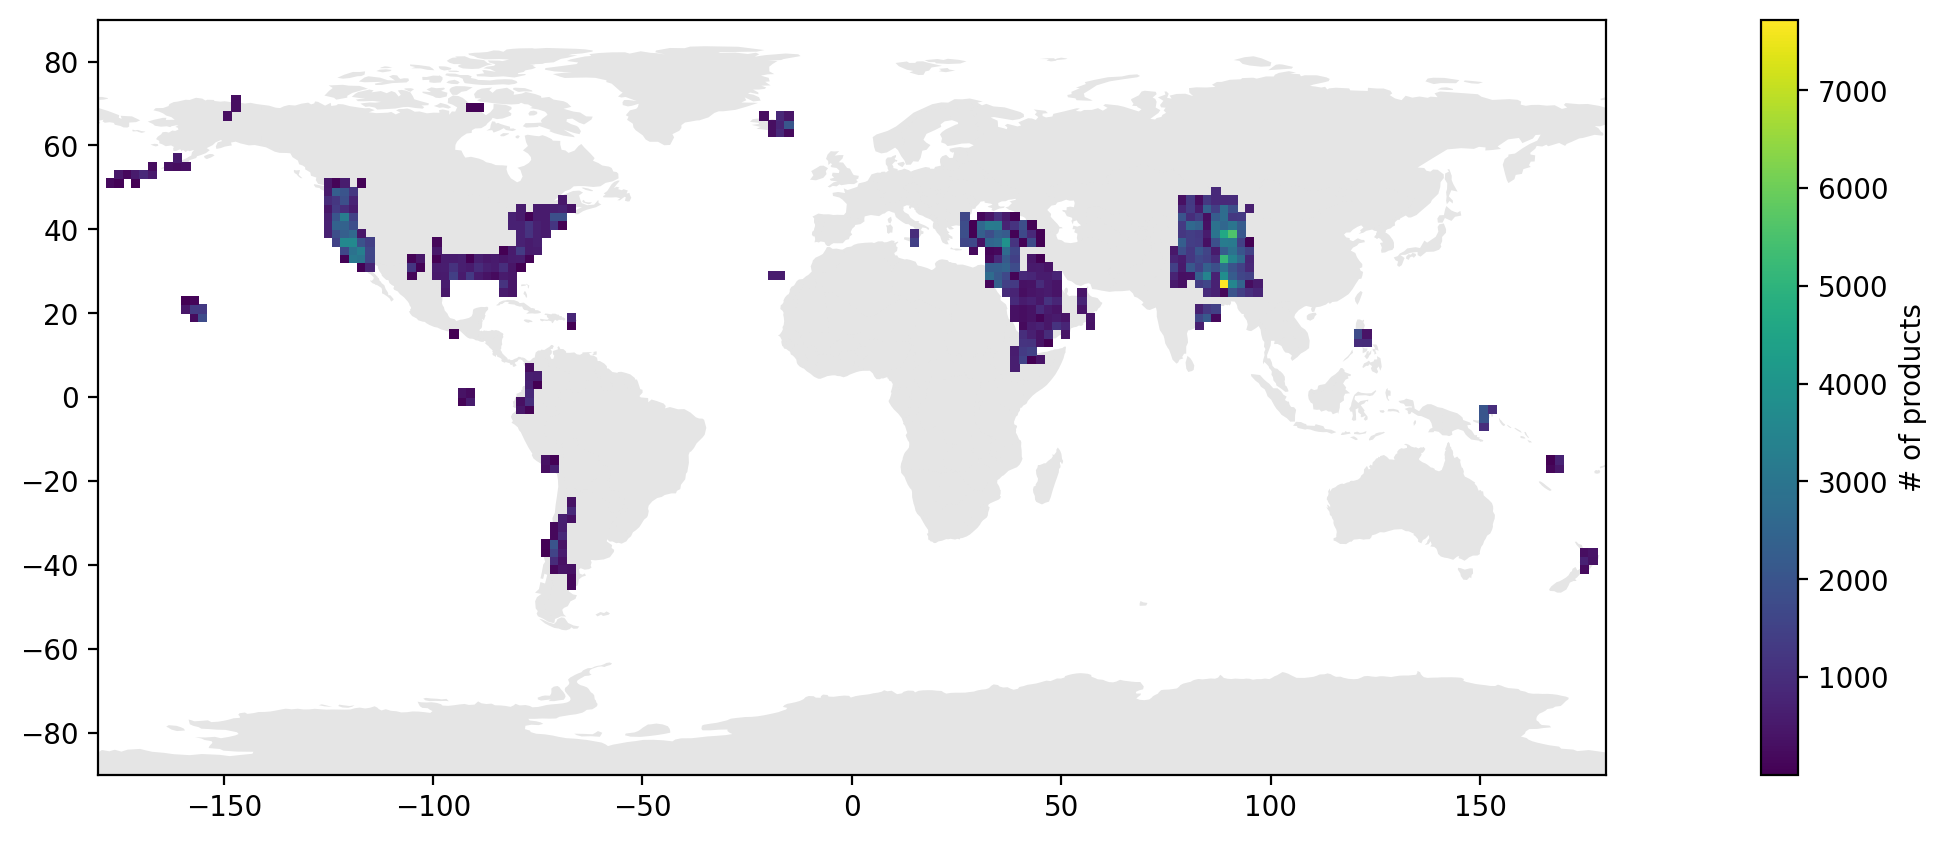

In [13]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=200)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='black', zorder=1, alpha=.1)

heat_data2 = [[point.xy[0][0], point.xy[1][0]] for point in df_points.geometry]
x, y = zip(*heat_data2)

deg = deg_bin_size
im_range = ((-180, 180), ((-90, 90)))
bins = (int(360/deg), int(180/deg))

data = ax.hist2d(x, y,
                 range=im_range,
                 bins=bins, 
                 alpha=1, 
                 cmin=1)

ax.set_ylim(-90, 90)
fig.colorbar(data[3], ax=ax, label='# of products')

## Folium

Legend I can't figure out. Still looks nice.

In [14]:
# from folium import plugins
# import branca.colormap as cm
# from collections import defaultdict

# map = folium.Map(location = [15,30], tiles='Cartodb positron', zoom_start = 2)

# heat_data = [[point.xy[1][0], point.xy[0][0]] for point in df_points.geometry ]

# plugins.HeatMap(heat_data,
#                 blur=10,
#                 radius=15).add_to(map)

# map

# Plot Growth

In [15]:
df['updated'] = pd.to_datetime(df['updated'])
df_t = df[['producer_granule_id', 'updated']].set_index('updated')

## Monthly all time

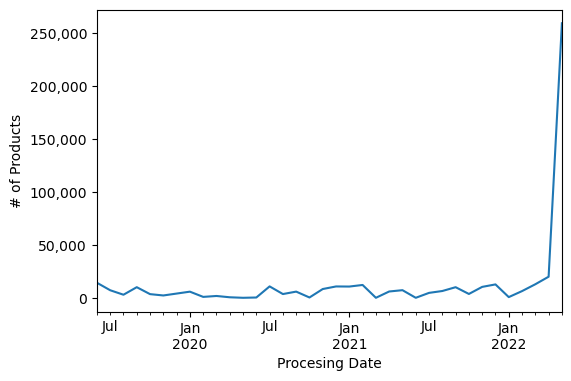

In [16]:
fig, ax = plt.subplots(dpi=100)

df_p = df_t['producer_granule_id'].resample('1M').count()
ax = df_p.plot(ax=ax)
ax.set_xlabel('Procesing Date')
ax.set_ylabel('# of Products')

ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

## Daily last two months

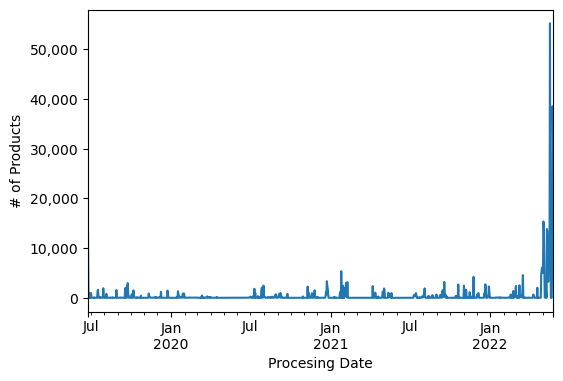

In [17]:
fig, ax = plt.subplots(dpi=100)

df_d = df_t['producer_granule_id'].resample('1D').count()
ax = df_d.plot(ax=ax)
ax.set_xlabel('Procesing Date')
ax.set_ylabel('# of Products')

ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

In [18]:
import datetime

today = datetime.datetime.now()
indices = df_d.index > pd.to_datetime(today - datetime.timedelta(days=62), utc=True)
df_p = df_d[indices]

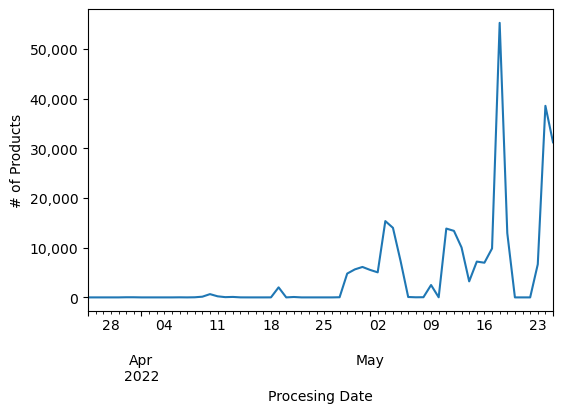

In [19]:
fig, ax = plt.subplots(dpi=100)

ax = df_p.plot(ax=ax)
ax.set_xlabel('Procesing Date')
ax.set_ylabel('# of Products')

ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

In [20]:
f'Total products: {df.shape[0]:,}'

'Total products: 474,427'